# BAYESIAN MODEL SELCTION WITH `PyMC3`
## Preliminaries
### Imports

In [1]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sbn
import pymc3             as pm

### Notebook settings

In [2]:
%matplotlib notebook

### Legend parameters
... for adding nice little legends onto our plots.

In [3]:
legend_params = {'loc': 'best',
                 'frameon': True, 
                 'fancybox': True, 
                 'framealpha': 0.7}

## Create Synthetic Polynomial Data with Gaussian Noise
Feel free to play around with the commented parameters below!

<IPython.core.display.Javascript object>


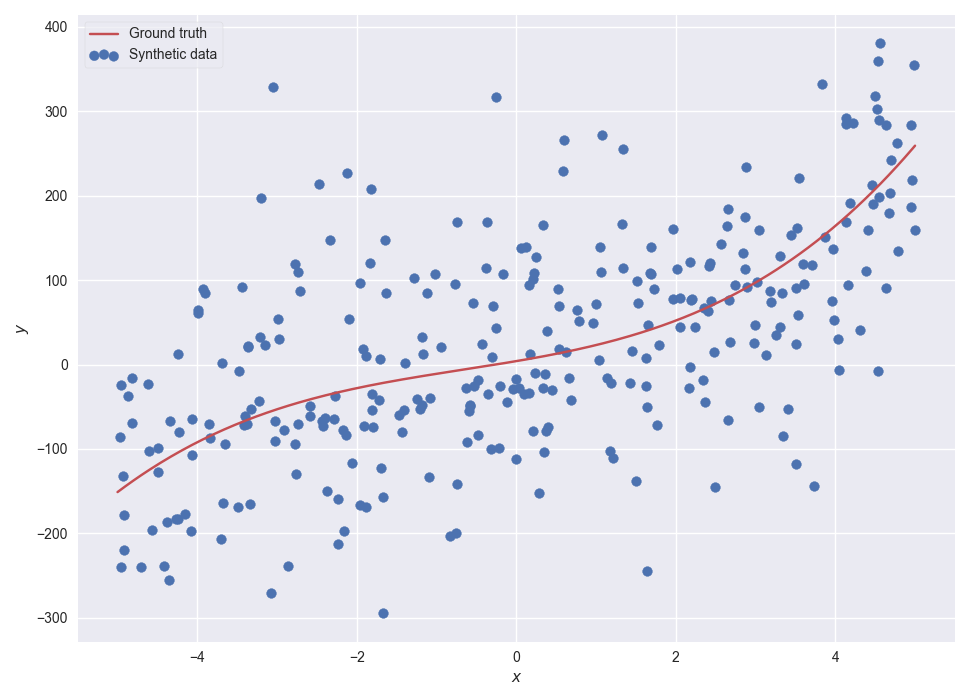

In [4]:
n_draws = 300   # Number of samples
x_lower = -5.0  # Lower bound of x-values
x_upper = +5.0  # Upper bound of x-values

α_true = 4.0    # The CONSTANT used to generate the synthetic polynomial data
β_true = 16.0   # The LINEAR coefficient used to generate the synthetic, polynomial data
γ_true = 2.0    # The QUADRATIC coefficient used to generate the synthetic, polynomial data
δ_true = 1.0    # The CUBIC coefficient used to generate the synthetic, polynomial data
σ_true = 100.0  # The STANDARD DEVIATION of the Gaussian noise of the synthetic data

x_true = np.linspace(x_lower, x_upper, n_draws)
y_true = α_true + β_true*x_true + γ_true*x_true**2 + δ_true*x_true**3

x = np.random.uniform(x_lower, x_upper, n_draws)
ϵ = np.random.normal(0, σ_true, n_draws)
y = α_true + β_true*x + γ_true*x**2 + δ_true*x**3 + ϵ

fig, ax = plt.subplots(figsize=(9.7, 7))

ax.scatter(x, y, label='Synthetic data')
ax.plot(x_true, y_true, color='#c44e52', label='Ground truth')
ax.legend(scatterpoints=3, **legend_params)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

fig.tight_layout()

## Perform Bayesian Regression
First, we set the number $N$ of samples in the Markov-Chain Monte-Carlo (MCMC) integration.

In [5]:
N = 10000

Then, we fit three polynomial models with degrees 1, 2 and 3. We take 
+ Normal priors on the coefficients (with their means set to their respective true values) and a
+ half-Normal prior on the standard deviation of the Gaussian noise.

The standard deviations of all (half) Gaussian priors are set to the resepective true values as well with a 1 added in case the true values are set to zero. This choice already yields a fairly good starting point for the sampler, which is intended because inferring the model parameters is not the point of the present exercise in model comparison.

### Linear model
Let's start with a linear model of the form
$$\mathbf{y} = \alpha + \beta\,\mathbf{x}$$

In [6]:
with pm.Model() as l_model:
    α = pm.Normal('alpha', mu=α_true, sd=α_true+1)
    β = pm.Normal('beta', mu=β_true, sd=β_true+1)
    
    μ = α + β*x
    σ = pm.HalfNormal('sigma', sd=σ_true+1)
        
    y_obs = pm.Normal('y', mu=μ, sd=σ, observed=y)
    
    l_trace = pm.sample(N, init='advi_map')

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Optimization terminated successfully.
         Current function value: 1836.548973
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16


Average Loss = 1,850.2:   5%|▍         | 9547/200000 [00:01<00:33, 5725.38it/s]
Convergence archived at 9900
Interrupted at 9,900 [4%]: Average Loss = 1,931.2
100%|██████████| 10500/10500 [00:27<00:00, 387.15it/s]


### Quadratic model
Next, we fit a quadratic model of the form
$$\mathbf{y} = \alpha + \beta\,\mathbf{x} + \gamma\,\mathbf{x}^2$$

In [7]:
with pm.Model() as q_model:
    α = pm.Normal('alpha', mu=α_true, sd=α_true+1)
    β = pm.Normal('beta', mu=β_true, sd=β_true+1)
    γ = pm.Normal('gamma', mu=γ_true, sd=γ_true+1)
    
    μ = α + β*x + γ*x**2
    σ = pm.HalfNormal('sigma', sd=σ_true+1)
        
    y_obs = pm.Normal('y', mu=μ, sd=σ, observed=y)
    
    q_trace = pm.sample(N, init='advi_map')

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Optimization terminated successfully.
         Current function value: 1834.421329
         Iterations: 16
         Function evaluations: 19


Average Loss = 1,844.2:   5%|▌         | 10415/200000 [00:01<00:31, 5982.55it/s]
Convergence archived at 10600
Interrupted at 10,600 [5%]: Average Loss = 1,908.5
100%|██████████| 10500/10500 [00:26<00:00, 401.56it/s]

         Gradient evaluations: 19


### Cubic model
And, finally, we fit a cubic model of the form
$$\mathbf{y} = \alpha + \beta\,\mathbf{x} + \gamma\,\mathbf{x}^2 + \delta\,\mathbf{x}^3$$

In [8]:
with pm.Model() as c_model:
    α = pm.Normal('alpha', mu=α_true, sd=α_true+1)
    β = pm.Normal('beta', mu=β_true, sd=β_true+1)
    γ = pm.Normal('gamma', mu=γ_true, sd=γ_true+1)
    δ = pm.Normal('delta', mu=δ_true, sd=δ_true+1)
    
    μ = α + β*x + γ*x**2 + δ*x**3
    σ = pm.HalfNormal('sigma', sd=σ_true+1)
        
    y_obs = pm.Normal('y', mu=μ, sd=σ, observed=y)
    
    c_trace = pm.sample(N, init='advi_map')

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Optimization terminated successfully.
         Current function value: 1829.813625
         Iterations: 19


Average Loss = 1,835:   5%|▌         | 10074/200000 [00:01<00:37, 5001.65it/s] 
Convergence archived at 10200
Interrupted at 10,200 [5%]: Average Loss = 1,910.9
100%|██████████| 10500/10500 [00:37<00:00, 280.09it/s]

         Function evaluations: 23
         Gradient evaluations: 23


## Model Comparison
### The basics

The Bayesian evidence $p\left(\mathcal{M}\vert\mathcal{D}\right)$, for a model $\mathcal{M}$ given the data $\mathcal{D}$, is given by Bayes' theorem

$$p\left(\mathcal{M}\vert\mathcal{D}\right) = 
 \frac{p\left(\mathcal{D}\vert\mathcal{M}\right)\,\pi\left(\mathcal{M}\right)}{p\left(\mathcal{D}\right)}$$

where $p\left(\mathcal{D}\vert\mathcal{M}\right)$ is the model likelihood, $\pi\left(\mathcal{M}\right)$ the prior probability of the model, and $p\left(\mathcal{D}\right)$ the marginal probability of the data.

As our task here is to compare two models, $\mathcal{M}_1$ and $\mathcal{M}_2$, we don't need that last term, which is the same for both models. Instead, we are only interested in the evidence ratio

$$\frac{p\left(\mathcal{M}_1\vert\mathcal{D}\right)}{p\left(\mathcal{M}_2\vert\mathcal{D}\right)} = 
 \frac{p\left(\mathcal{D}\vert\mathcal{M}_1\right)}{p\left(\mathcal{D}\vert\mathcal{M}_2\right)}\frac{\pi\left(\mathcal{M}_1\right)}{\pi\left(\mathcal{M}_2\right)}$$

where the first term on the right is the _Bayes factor_ and the second term is the prior odds. We disregard this last term here as its treatment is trivial. Rather, we focus on the likelihood of a model $\mathcal{M}$ with parameters $\boldsymbol{\theta}$.

$$p\left(\mathcal{D}\vert\mathcal{M}\right) = \int\text{d}\boldsymbol{\theta}\;p\left(\mathcal{D}\vert\boldsymbol{\theta}, \mathcal{M}\right)\,p\left(\boldsymbol{\theta}\right)$$

where $p\left(\mathcal{D}\vert\boldsymbol{\theta}, \mathcal{M}\right)$ is the likelihood of the model parameters given the data and $p\left(\boldsymbol{\theta}\right)$ is the posterior probability of the model parameters.

### Monte-Carlo integration

One way of computing the model likelihood would be to use Monte-Carlo integration, where the expectation value $\mathbb{E}$ of any function $f\left(x\right)$ with respect to the probability density function $p\left(x\right)$ of $x$ is approximated by

$$\mathbb{E}\left[f\left(x)\right)\right]=\int\text{d}x\;f\left(x\right)\,p\left(x\right)\approx\frac{1}{N}\sum_{i=1}^N f\left(x\right)$$

where the sum runs over $N$ samples of $x$, randomly drawn from $p\left(x\right)$.

### Using traces and likelihood from an MCMC run
If we used MCMC to infer the parameters $\boldsymbol{\theta}$ of model $\mathcal{M}$ in the first place, then we already have $N$ samples from their posterior distribution $p\left(\boldsymbol{\theta}\right)$ and, most likely, we also have an efficient way to calculate their likelihood $p\left(\mathcal{D}\vert\boldsymbol{\theta}, \mathcal{M}\right)$. Consequently, it could be possible to use our MCMC machinery to get also an approximation for the likelihood $p\left(\mathcal{D}\vert\mathcal{M}\right)$ of $\mathcal{M}$.

As it where, however, `pymc3` only offers to compute the _logarithm_ of the likelihood for a given set of model paramters. Let's do this for, say, the linear model.

In [9]:
l_logp = np.fromiter((l_model.logp(l_trace.point(i)) for i in range(N)),
                     dtype=np.float64,
                     count=N)
l_logp

array([-1837.69772207, -1837.836773  , -1837.12046016, ..., -1837.90186986,
       -1837.37628375, -1837.85097348])

In order to approximate the integral giving us the expected model likelihood, we need to raise Euler's number $e$ to the power of all this numbers _first_ and only _then_ sum them up. Let's try.

In [10]:
(1/N)*np.exp(l_logp).sum()

0.0

Unfortunately, the likelihood of any posterior sample from the model parameters is too small to give a meaningful number for the overall model likelihood.

### Dealing with small numbers
Apparently, there is a good reason why `pymc3` reports only the _logarithm_ of the likelihoods and we should probably do the same, that is, we should seek to compute the logarithm of the model likelihood as well.

$$\log\left[p\left(\mathcal{D}\vert\mathcal{M}\right)\right]\approx\log\left[\frac{1}{N}\sum_{i=1}^N p\left(\mathcal{D}\vert\boldsymbol{\theta}_i,\mathcal{M}\right)\right]=\log\left[\sum_{i=1}^N p\left(\mathcal{D}\vert\boldsymbol{\theta}_i,\mathcal{M}\right)\right]-\log\left(N\right)$$

As we are only provided with log-likelihoods, we should rewrite this as:

$$\log\left[p\left(\mathcal{D}\vert\mathcal{M}\right)\right]\approx\log\left[\sum_{i=1}^N e^{\log\left[p\left(\mathcal{D}\vert\boldsymbol{\theta}_i,\mathcal{M}\right)\right]}\right]-\log\left(N\right)$$

To get rid of the underflows in the sum, we employ the identity

$$\log\left(\sum_{i=1}^N e^{y_i}\right)=c+\log\left(\sum_{i=1}^N e^{y_i-c}\right)$$

with $y_i = \log\left[p\left(\mathcal{D}\vert\boldsymbol{\theta}_i,\mathcal{M}\right)\right]$ in our case. For the arbitrary constant $c$, we conveniently choose $\max\left(y_i\right)$ so that the largest term in the sum is unity.

Thus, with

$$c=\max_{\boldsymbol{\theta}_i}\left\{\log\left[p\left(\mathcal{D}\vert\boldsymbol{\theta}_i,\mathcal{M}\right)\right]\right\}$$

we finally have:

$$\log\left[p\left(\mathcal{D}\vert\mathcal{M}\right)\right]\approx c+\log\left[\sum_{i=1}^N e^{log\left[p\left(\mathcal{D}\vert\boldsymbol{\theta}_i,\mathcal{M}\right)\right]-c}\right]-\log\left(N\right)$$

Let's implement this in a little function ...

In [11]:
def log_evidence(model, trace, N):
    logp = np.fromiter((model.logp(trace.point(i)) for i in range(N)),
                       dtype=np.float64,
                       count=N)
    const = logp.max()
    loge = const + np.log(np.exp(logp - const).sum()) - np.log(N)
    return loge

... and try again for the linear model.

In [12]:
l_logE = log_evidence(l_model, l_trace, N)
l_logE

-1837.5793750923413

Much better! But we still cannot get the (unnormalized) model evidence.

In [13]:
np.exp(l_logE)

0.0

That number ist still too small.

### Bayes factors
Recall that what we really need is the Bayes factor, that is, the ratio of the evidences of models $\mathcal{M}_1$ and $\mathcal{M}_2$. For the logarithm of this ratio, we have

$$\text{log}\left[\frac{p\left(\mathcal{M}_1\vert\mathcal{D}\right)}{p\left(\mathcal{M}_2\vert\mathcal{D}\right)} \right]=\text{log}\left[p\left(\mathcal{M}_1\vert\mathcal{D}\right)\right]-\text{log}\left[p\left(\mathcal{M}_2\vert\mathcal{D}\right)\right]=\Delta_{\text{log}}\left(\mathcal{M}_1, \mathcal{M}_2\right)$$

so we first need to take the pairwise differences $\Delta_{\text{log}}$ between the numbers we just learned to compute before we get the actual Bayes factors as:

$$\frac{p\left(\mathcal{M}_1\vert\mathcal{D}\right)}{p\left(\mathcal{M}_2\vert\mathcal{D}\right)} = e^{\Delta_{\text{log}}\left(\mathcal{M}_1, \mathcal{M}_2\right)}$$

In [14]:
q_logE = log_evidence(q_model, q_trace, N)
c_logE = log_evidence(c_model, c_trace, N)

Δ_cq = c_logE - q_logE
Δ_cl = c_logE - l_logE
Δ_ql = q_logE - l_logE

print('Bayes factor cubic/quadratic:', np.exp(Δ_cq))
print('Bayes factor cubic/linear:', np.exp(Δ_cl))
print('Bayes factor quadratic/linear:', np.exp(Δ_ql))

Bayes factor cubic/quadratic: 71.4193556942
Bayes factor cubic/linear: 423.457022942
Bayes factor quadratic/linear: 5.92916330351


Depending on our prior belief on which model is best, we can now produce a posteriori measure of how good a given model is compared to another. If we think all models could equally well be the best, that is, all priors are the same, then the result is already what we just calculated.

## Notes on Convergence
As the number of model parameters increases, so does the dimensionality of the space on which we integrate to get our model evidence. Accordingly, the number of MC samples we need to get a satisfactory approximation to our Bayes factors increases. Let's check convergence for our simple model system.

In [15]:
burn_in = 500
step_size = 100

lengths = range(burn_in, N+1, step_size)
stepcnt = len(lengths)
l_logEs = np.fromiter((log_evidence(l_model, l_trace, n) for n in lengths),
                      dtype=np.float64,
                      count=stepcnt)
q_logEs = np.fromiter((log_evidence(q_model, q_trace, n) for n in lengths),
                      dtype=np.float64,
                      count=stepcnt)
c_logEs = np.fromiter((log_evidence(c_model, c_trace, n) for n in lengths),
                      dtype=np.float64,
                      count=stepcnt)

factors_cq = np.exp(c_logEs - q_logEs)
factors_cl = np.exp(c_logEs - l_logEs)
factors_ql = np.exp(q_logEs - l_logEs)

<IPython.core.display.Javascript object>


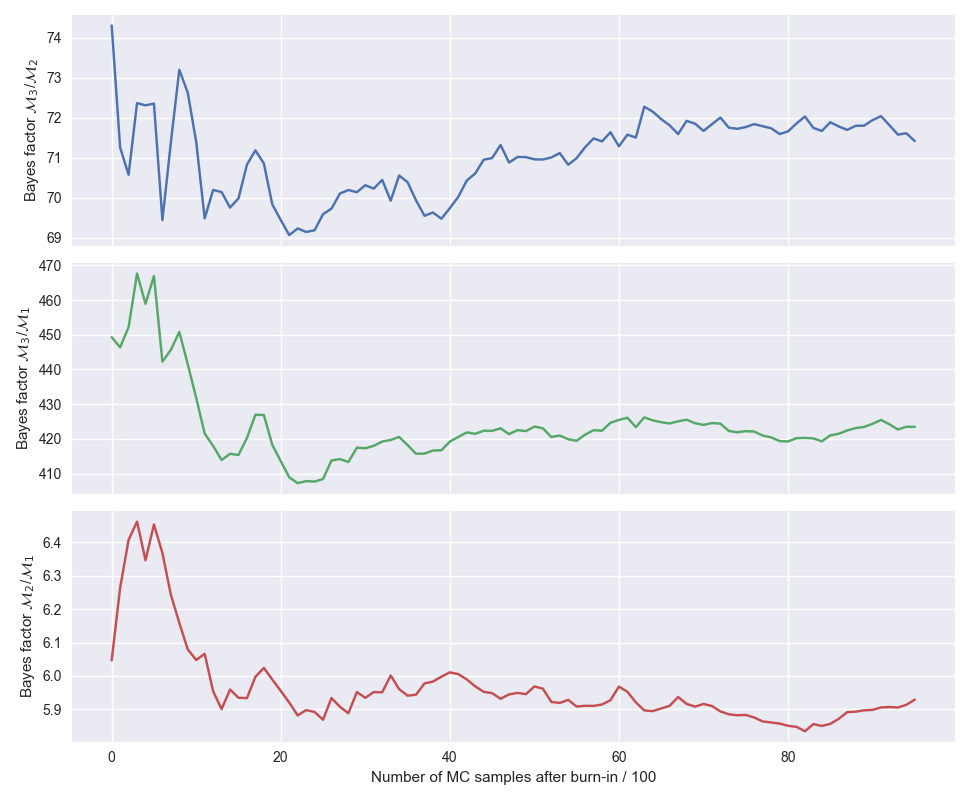

In [16]:
fig, (cq_ax, cl_ax, ql_ax) = plt.subplots(3, 1, sharex=True, figsize=(9.7, 8))
x_label = f'Number of MC samples after burn-in / {step_size}'

cq_ax.plot(factors_cq)
cq_ax.set_ylabel(r'Bayes factor $\mathcal{M}_3$/$\mathcal{M}_2$')

cl_ax.plot(factors_cl, color='#55a868')
cl_ax.set_ylabel(r'Bayes factor $\mathcal{M}_3$/$\mathcal{M}_1$')

ql_ax.plot(factors_ql, color='#c44e52')
ql_ax.set_ylabel(r'Bayes factor $\mathcal{M}_2$/$\mathcal{M}_1$')
ql_ax.set_xlabel(x_label)

fig.tight_layout()

Before we make any judgement on convergence, let's look at that again, this time plotted as percentage changes.

<IPython.core.display.Javascript object>


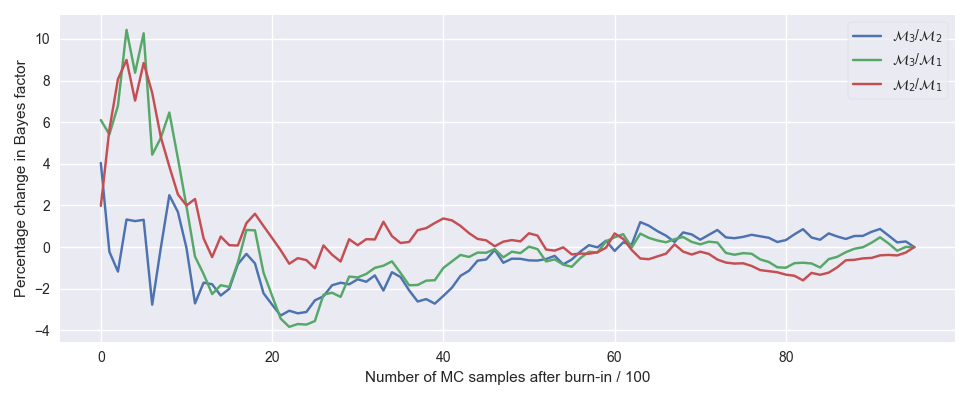

In [17]:
fig, ax = plt.subplots(figsize=(9.7, 4))

ax.plot(100*(factors_cq/np.exp(Δ_cq) - 1),
        label=r'$\mathcal{M}_3$/$\mathcal{M}_2$')
ax.plot(100*(factors_cl/np.exp(Δ_cl) - 1),
        label=r'$\mathcal{M}_3$/$\mathcal{M}_1$')
ax.plot(100*(factors_ql/np.exp(Δ_ql) - 1),
        label=r'$\mathcal{M}_2$/$\mathcal{M}_1$')
ax.set_xlabel(x_label)
ax.set_ylabel('Percentage change in Bayes factor')
ax.legend(loc='best', frameon=True, fancybox=True, framealpha=0.7)

fig.tight_layout()

Certainly not ideal but not too bad either. As the attribute "converged" only makes sense on a _relative_ scale, we have to compare these convergence curves to the convergence of something else in order to make a more quantitative statement. Let's first write a little helper function ... 

In [52]:
def mean_of_one(trace):
    return np.fromiter((trace[:n].mean() for n in lengths),
                       dtype=np.float64,
                       count=stepcnt)

def rel_means_of(trace):
    means = np.array([mean_of_one(trace[name]) for name in trace.varnames])
    means /= means[:,-1:]
    return 100*(means.T - 1)

... and then look at the convergence of the model-parameter means, plotted again as relative changes.

<IPython.core.display.Javascript object>


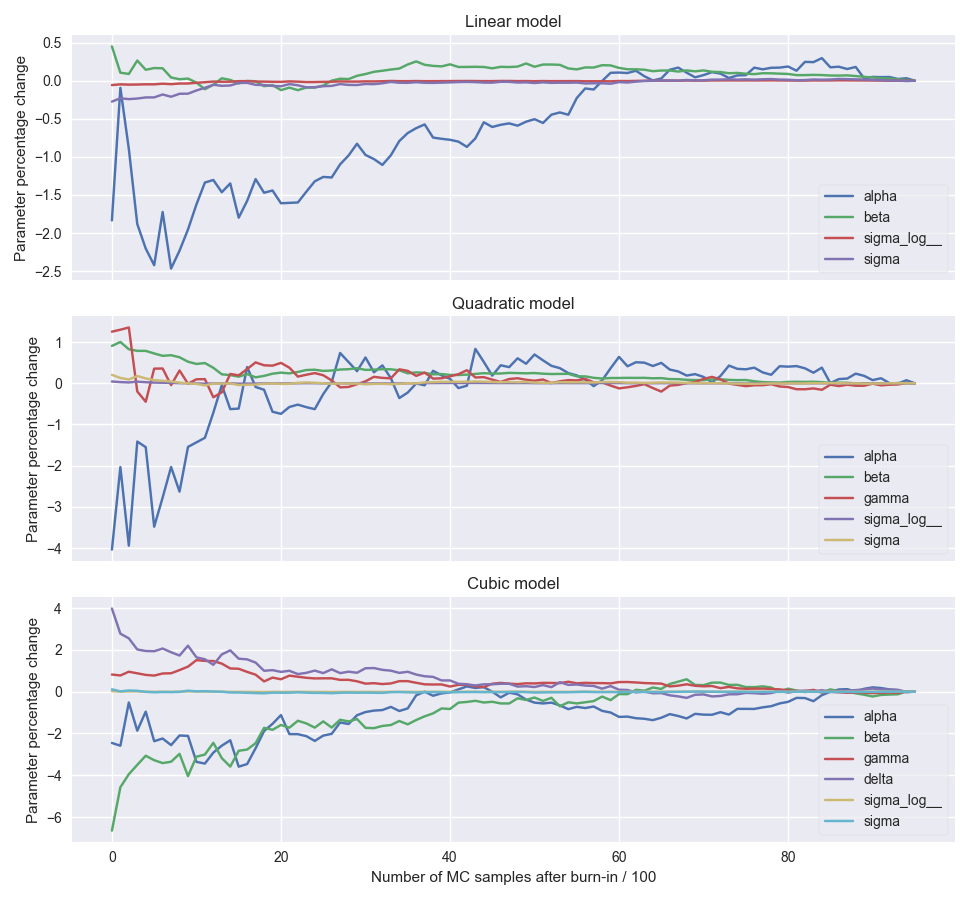

In [53]:
fig, (l_ax, q_ax, c_ax) = plt.subplots(3, 1, sharex=True, figsize=(9.7, 9))
y_label = 'Parameter percentage change'

lines = l_ax.plot(rel_means_of(l_trace))
l_ax.legend(lines, l_trace.varnames, **legend_params)
l_ax.set_ylabel(y_label)
l_ax.set_title('Linear model')

lines = q_ax.plot(rel_means_of(q_trace))
q_ax.legend(lines, q_trace.varnames, **legend_params)
q_ax.set_ylabel(y_label)
q_ax.set_title('Quadratic model')

lines = c_ax.plot(rel_means_of(c_trace))
c_ax.legend(lines, c_trace.varnames, **legend_params)
c_ax.set_ylabel(y_label)
c_ax.set_title('Cubic model')
c_ax.set_xlabel(x_label)

fig.tight_layout()

Overall, the convergence of our Bayes factors seems similar to that of the model parameters. So, at least in the case of our simple model, the procedure proposed here to compute Bayes factors seems viable.